In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read in the cleaned audio features file as a pandas dataframe

audio_features = pd.read_csv('audio_features.csv', index_col='track_id')
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [3]:
# scale tempo using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

audio_features.tempo = MinMaxScaler().fit_transform(audio_features.tempo.values.reshape(-1,1))
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072


Now I implement the hierarchical agglomerative clustering algorithm with single, complete, and average linkage.

In [4]:
def hac(X, n_clusters, linkage):
    
    # initiate list of clusters where each point is a cluster
    clusters = [[i] for i in range(len(X))]
    
    # initialize array of cluster labels
    n = len(clusters)
    cluster_labels = np.zeros(n)
    
    # compute matrix of euclidean distances between all data points
    dist_mat = euclidean_distances(X, X)
    
    # iterate until only the desired number of clusters remains
    while n_clusters < len(clusters):
        
        # arbitrary large number as initial minimum value
        min_val = 99999999
        m = len(dist_mat)
        
        # loop through matrix rows and columns to find the minimum distance and its indices
        for i in range(m):
            for j in range(i+1, m):
                if (dist_mat[i][j] < min_val) and (i != j):
                    min_val = dist_mat[i][j]
                    idx, idy = i, j
                    
        # update the clusters
        clusters[idx].extend(clusters[idy])
        
        # delete merged point from cluster list
        del clusters[idy]
        
        # update the distance matrix based on linkage type
        for i in range(m):
            if linkage == 'single':
                dist_mat[idx][i] = dist_mat[i][idx] = min(dist_mat[idx][i], dist_mat[idy][i])
            elif linkage == 'complete':
                dist_mat[idx][i] = dist_mat[i][idx] = max(dist_mat[idx][i], dist_mat[idy][i])
            elif linkage == 'average':
                dist_mat[idx][i] = dist_mat[i][idx] = (dist_mat[idx][i] + dist_mat[idy][i])/2
        
        # delete merged point from distance matrix
        dist_mat = np.delete(dist_mat,idy,0)
        dist_mat = np.delete(dist_mat,idy,1)
        
    # update cluster labels
    new_n = len(clusters)
    for x in range(new_n):
        for y in clusters[x]:
            cluster_labels[y] = x
            
    cluster_labels = cluster_labels.astype(int)
                
    return clusters, cluster_labels

# partial source: https://github.com/SnehaParshwanath/Clustering/blob/master/Hierarchical_Clustering.py
# full reference in bibliography

In [5]:
# apply PCA on dataset to reduce the number of dimensions to 2 for visualization

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(audio_features)

In [6]:
# create subset of data to apply the algorithm on

X = X[:2000]

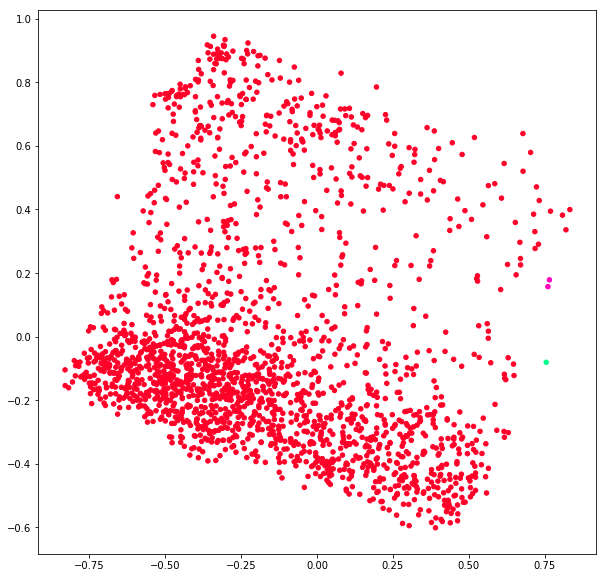

In [7]:
# apply algorithm with single linkage on data subset and visualize the clusters formed

clusters_s, cluster_labels_s = hac(X, 3, 'single')
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=cluster_labels_s, cmap='gist_rainbow')
plt.show()

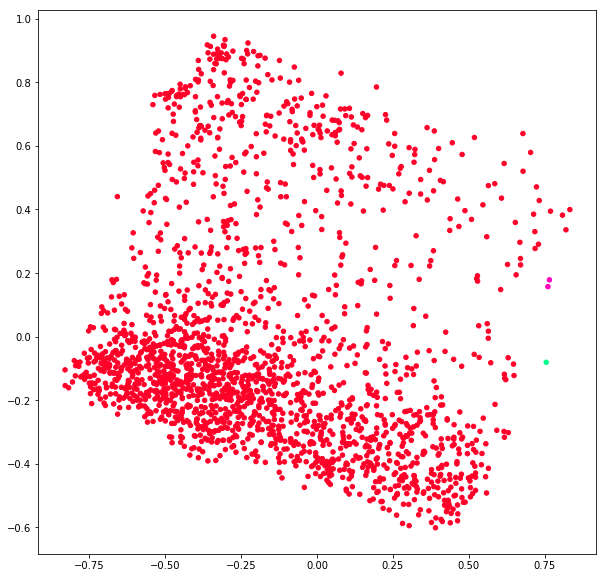

In [8]:
# compare with scikit-learn algorithm

from sklearn.cluster import AgglomerativeClustering

single = AgglomerativeClustering(n_clusters=3, linkage='single').fit(X)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=single.labels_, cmap='gist_rainbow')
plt.show()

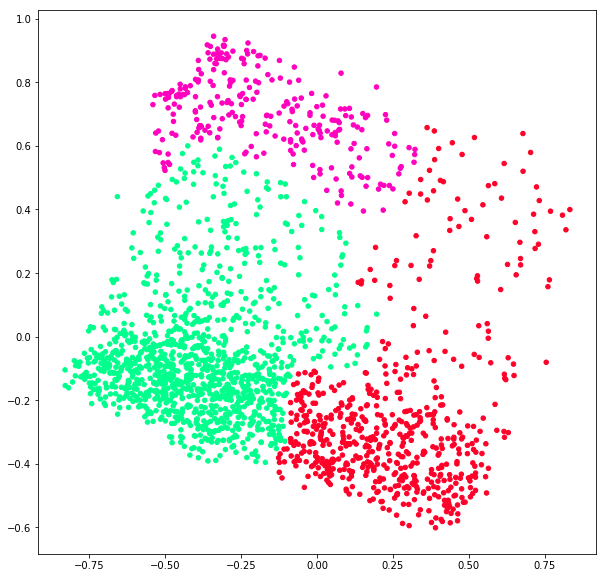

In [9]:
# apply algorithm with complete linkage on data subset and visualize the clusters formed

clusters_c, cluster_labels_c = hac(X, 3, 'complete')
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=cluster_labels_c, cmap='gist_rainbow')
plt.show()

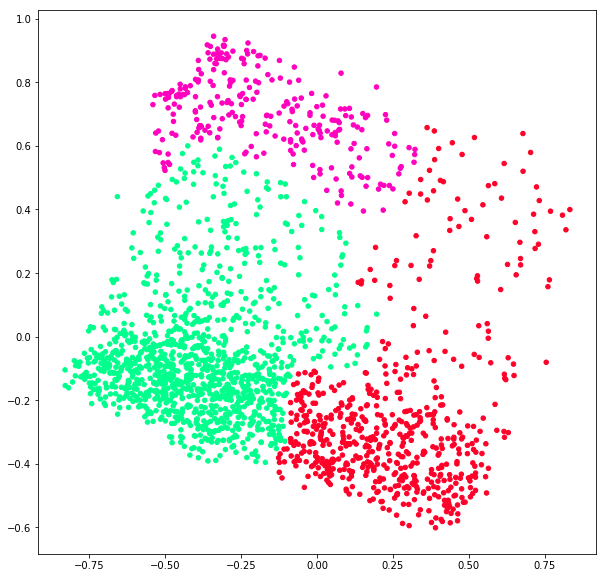

In [10]:
# compare with scikit-learn algorithm

complete = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(X)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=complete.labels_, cmap='gist_rainbow')
plt.show()

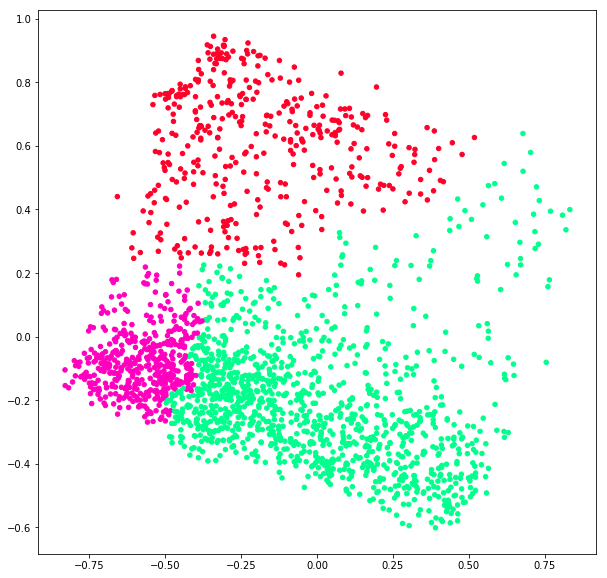

In [11]:
# apply algorithm with average linkage on data subset and visualize the clusters formed

clusters_a, cluster_labels_a = hac(X, 3, 'average')
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=cluster_labels_a, cmap='gist_rainbow')
plt.show()

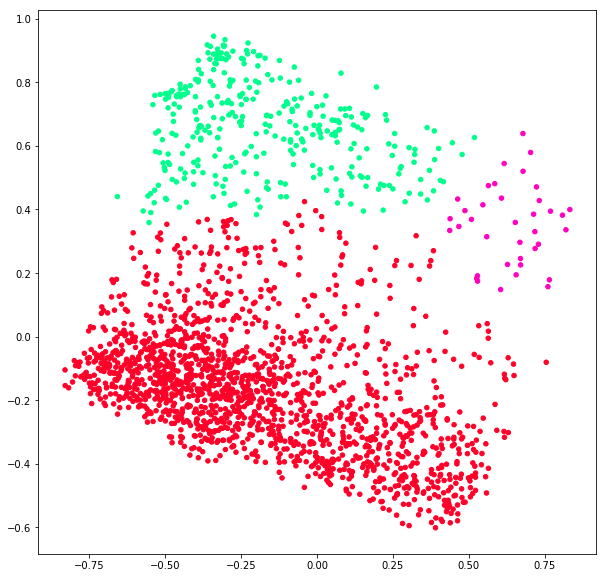

In [12]:
# compare with scikit-learn algorithm

average = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X)
plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1], s=20, c=average.labels_, cmap='gist_rainbow')
plt.show()

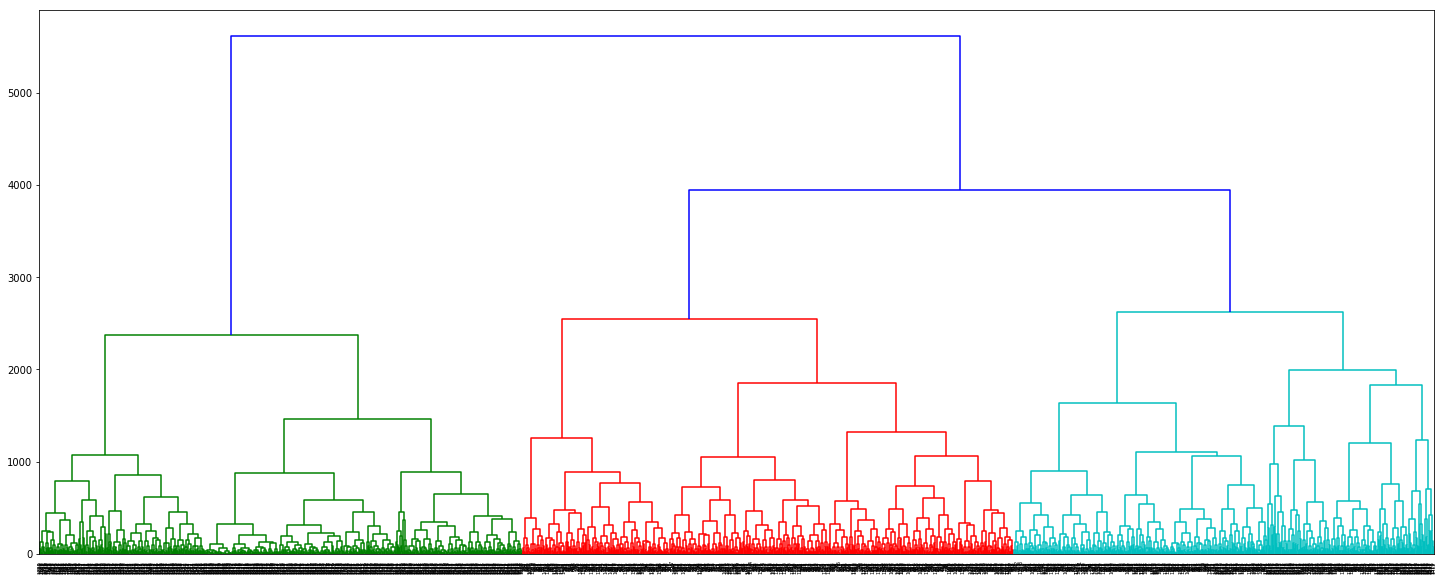

In [13]:
# create dendrogram using results of scikit-learn complete linkage algorithm

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(complete.children_, 'complete')
plt.figure(figsize=(25,10))
dendrogram(Z,show_leaf_counts=True,leaf_rotation=90)
plt.show()

In [14]:
# add selected cluster labels to dataframe

tracks = audio_features[:2000].copy()
tracks['hac_label'] = cluster_labels_c
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,hac_label
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,0
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,0
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,0
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,1
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,0


In [15]:
# take a look at cluster sizes

tracks.groupby('hac_label').size()

hac_label
0     601
1    1138
2     261
dtype: int64

In [16]:
# evaluate clustering results using scikit-learn metrics module

from sklearn import metrics

metrics.silhouette_score(X, cluster_labels_c, metric='euclidean')

0.45999239382951596

In [17]:
# create separate dataframes for each cluster for further analysis

cluster_1 = tracks.loc[(tracks['hac_label'] == 0)]
cluster_1 = cluster_1.drop(columns = ['hac_label'])
cluster_2 = tracks.loc[(tracks['hac_label'] == 1)]
cluster_2 = cluster_2.drop(columns = ['hac_label'])
cluster_3 = tracks.loc[(tracks['hac_label'] == 2)]
cluster_3 = cluster_3.drop(columns = ['hac_label'])

In [18]:
# create arrays of average values for each audio feature

avg_c1 = cluster_1.mean().values
avg_c2 = cluster_2.mean().values
avg_c3 = cluster_3.mean().values

In [19]:
# take a look at the clusters formed

data = np.array([avg_c1, avg_c2, avg_c3])
audio_feat_list = audio_features.columns.tolist()
clusters = pd.DataFrame(data, columns=audio_feat_list)
clusters

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,0.229519,0.400047,0.700399,0.770159,0.185751,0.094707,0.497048,0.400321
1,0.864933,0.398566,0.465177,0.811894,0.192083,0.082174,0.463465,0.384042
2,0.854964,0.469321,0.326864,0.044351,0.220996,0.208431,0.449128,0.467980


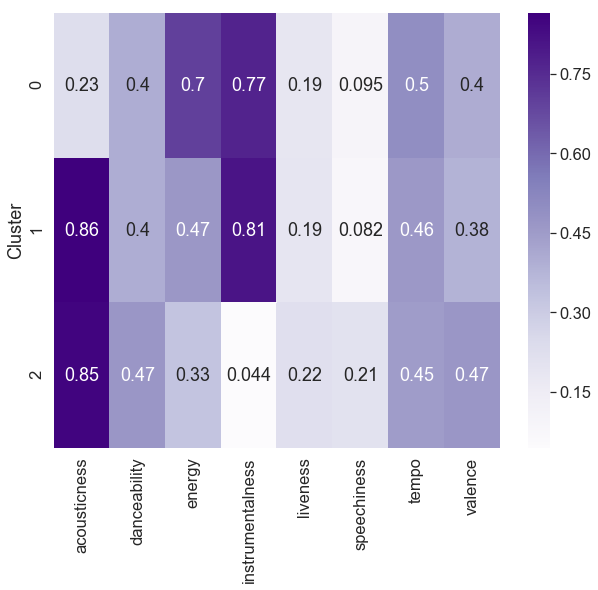

In [23]:
# visualize clusters in the form of a heatmap

plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
sns.heatmap(data=clusters,cmap='Purples',annot=True)
plt.ylabel('Cluster')
plt.show()

In [24]:
# read in the cleaned tracks with genre labels

track_genres = pd.read_csv('merged.csv', index_col='track_id')
track_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,genres,genres_all
track_id,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop,[21],[21]
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop,[21],[21]
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop,[21],[21]
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop,[10],[10]
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop,[21],[21]


In [25]:
# take a look at the genres and their counts

track_genres_subset = track_genres[:2000]
track_genres_subset.groupby('genre_top').size()

genre_top
Blues                    40
Classical                 7
Electronic              262
Folk                    250
Hip-Hop                  53
International            63
Jazz                     29
Old-Time / Historic      30
Pop                     108
Psych-Rock                5
Rock                   1153
dtype: int64

In [26]:
# add genre labels

tracks['genre_top'] = track_genres_subset['genre_top'].values
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,hac_label,genre_top
track_id,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,0,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,0,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,0,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,1,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,0,Hip-Hop


Let's take a look at which genres have been grouped into each cluster.

In [27]:
# find genres with cluster label 0

cluster_1 = tracks.loc[(tracks['hac_label'] == 0)]
cluster_1['genre_top'].unique()

array(['Hip-Hop', 'Folk', 'Jazz', 'Rock', 'Electronic', 'Pop', 'Blues',
       'Classical', 'Psych-Rock', 'International'], dtype=object)

In [28]:
# find genres with cluster label 1

cluster_2 = tracks.loc[(tracks['hac_label'] == 1)]
cluster_2['genre_top'].unique()

array(['Pop', 'Folk', 'Jazz', 'Rock', 'Electronic', 'Blues', 'Hip-Hop',
       'International', 'Classical', 'Old-Time / Historic', 'Psych-Rock'],
      dtype=object)

In [29]:
# find genres with cluster label 2

cluster_3 = tracks.loc[(tracks['hac_label'] == 2)]
cluster_3['genre_top'].unique()

array(['Folk', 'Rock', 'Electronic', 'Blues', 'Hip-Hop', 'Pop',
       'International', 'Jazz', 'Old-Time / Historic'], dtype=object)

There doesn't seem to be a clear distinction between genres in these clusters, despite having been grouped based on audio features. This suggests that the audio features used in my analysis do not correspond to specific genres.